In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sys import path as path
path.append('../')
from libRC import diffRC,mapRC
plt.rcParams.update({'font.size': 16})

def RK4(y,t,dt,f,params):
    k1 = dt*f(y,t,params)
    k2 = dt*f(y+k1/2, t+dt/2,params)
    k3 = dt*f(y+k2/2, t+dt/2,params)
    k4 = dt*f(y+k3, t+dt,params)
    return y + (k1+2*k2+2*k3+k4)/6
    
def burnIn(Mburn,x0,t,dt,model,params):
    for i in range(1,Mburn):
        x0=RK4(x0,t,dt,model,params)
    return x0

def forwardInt(M,x,t,dt,model,params):
    for i in range(1,M):
        x[:,i]=RK4(x[:,i-1],t,dt,model,params)
    return x

def lorenz63(u,t,params):
    [sigma,rho,beta] = params
    [x, y, z] = u
    dxdt = sigma*(y-x)
    dydt = x*(rho-z)-y
    dzdt = x*y - beta*z
    return np.asarray([dxdt,dydt,dzdt])

In [29]:
#%% generate data
np.random.seed(11111)

D = 3
M = 15000
Mpred = M
Mplot = M//8
dt = 0.01
t = 0 # dummy variable

sigma = 10   # Prandlt number
rho = 28     # Rayleigh number
beta = 8.0/3
params = [sigma,rho,beta]

noiseLevel = 0.5
x = np.zeros((D,M+Mpred))
x[:,0] = [12,13,14]
x[:,0] = burnIn(3456,x[:,0],t,dt,lorenz63,params)
x = forwardInt(M+Mpred,x,t,dt,lorenz63,params)
y = x+np.random.normal(loc=0.0,scale=noiseLevel,size=x.shape)

x_in = x[:,:M]
x_pred = x[:,M:]
y_in = y[:,:M]
y_pred = y[:,M:]

-----------------------------------------------------------------
Differential Reservoir initiated.
Connection matrix is setup.
Input matrix is setup.
Listening phase in progress...
   100.0%
Listening phase completed. Time taken: 0.387 seconds.
-----------------------------------------------------------------
Training in progress...
Fit Error:       0.0026
Training phase completed. Time taken: 0.006 seconds.
-----------------------------------------------------------------
Echoing phase in progress...
   100.0%
Echoing phase completed. Time taken: 0.427 seconds.
-----------------------------------------------------------------
Inference phase in progress...
   100.0%
Inference phase completed. Time taken: 0.479 seconds.
-----------------------------------------------------------------


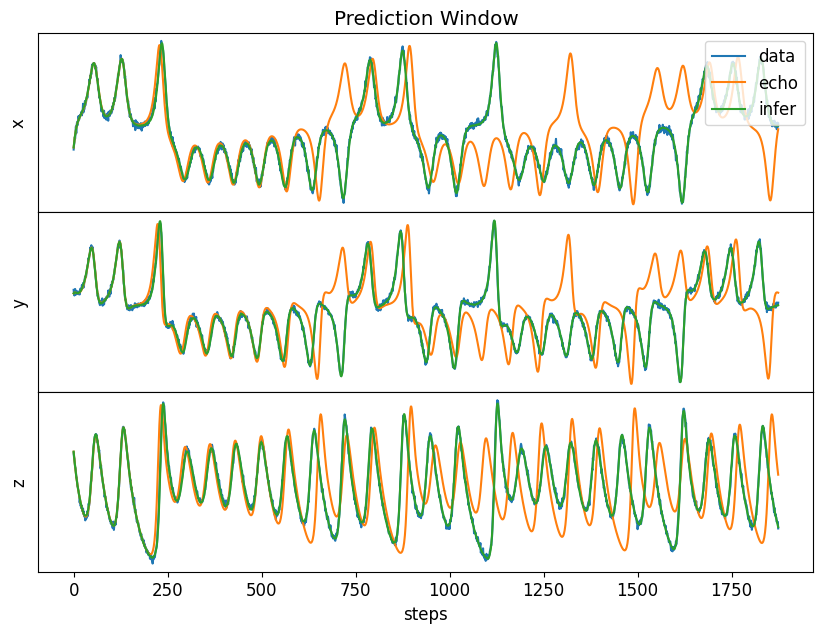

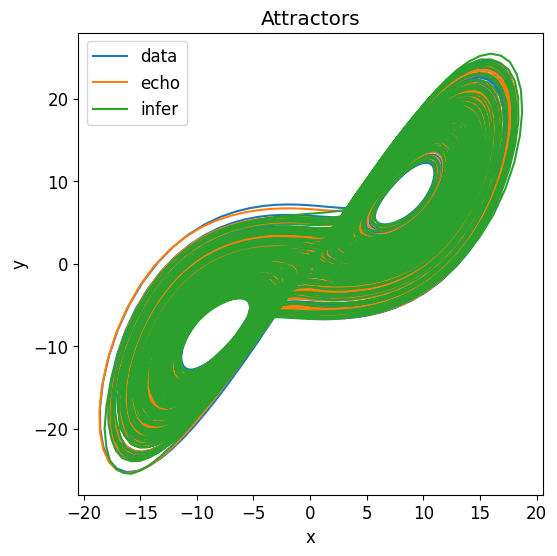

In [38]:
np.random.seed(11111)
N = 100
ds = 0.2
rho = 0.9
sigma = 2/max(np.max(y,1)-np.min(y,1))

RC = diffRC(N,ds,bias=False)

RC.makeConnectionMat(rho,density=0.02,loc=-1,scale=1)
RC.makeInputMat(D,sigma,randMin=-1,randMax=1)

RC.listen(y_in)
RC.train(y_in,alpha=0.0001)
RC.echo(Mpred)

driveIndex =[1]

RC.infer(y_pred[driveIndex],driveIndex)
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [10, 7]
fig,axs = plt.subplots(D,sharex='col')
fig.subplots_adjust(hspace=0)
labelList = ['x','y','z']
for i in range(D):
    axs[i].plot(y_pred[i,:Mplot],label='data')
    axs[i].plot(RC.y_echo[i,:Mplot],label='echo')
    axs[i].plot(RC.y_infer[i,:Mplot],label='infer')
    axs[i].set_xlabel('steps')
    axs[i].set_yticks([])
    axs[i].set_ylabel(labelList[i])
axs[0].legend(loc='upper right')
axs[0].set_title('Prediction Window')
plt.show()


plt.rcParams['figure.figsize'] = [6, 6]
plt.plot(x_pred[0],x_pred[1],label='data')
plt.plot(RC.y_echo[0],RC.y_echo[1],label='echo')
plt.plot(RC.y_infer[0],RC.y_infer[1],label='infer')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Attractors')
plt.legend()
plt.show()

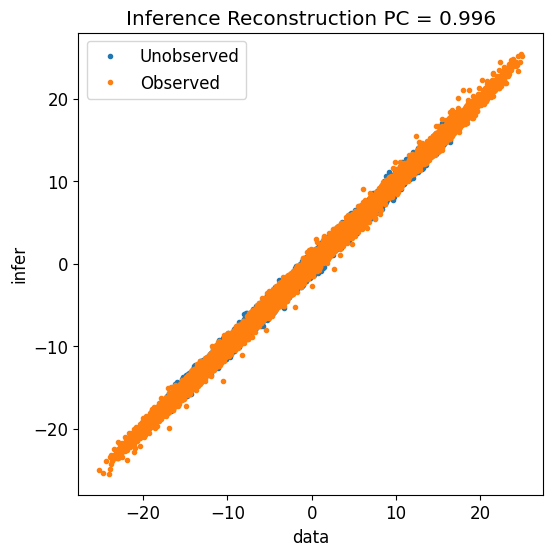

In [39]:
PCmat = RC.inferPC(y_pred)
plt.rcParams['figure.figsize'] = [6, 6]
plt.plot(y_pred[0],RC.y_infer[0],'.')
plt.plot(y_pred[1],RC.y_infer[1],'.')
plt.xlabel('data')
plt.ylabel('infer')
plt.title(f'Inference Reconstruction PC = {PCmat[0,0]:0.3f}')
plt.legend(['Unobserved','Observed'])
plt.show()